In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0')
val = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
test = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')

pbe_train = pd.DataFrame(data=[train['PBE Prediction'], train['PBE Target']]).transpose().dropna()
pbe_val = pd.DataFrame(data=[val['PBE Prediction'], val['PBE Target']]).transpose().dropna()
pbe_test = pd.DataFrame(data=[test['PBE Prediction'], test['PBE Target']]).transpose().dropna()

train = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0')
val = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
test = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')

scan_train = pd.DataFrame(data=[train['SCAN Prediction'], train['SCAN Target']]).transpose().dropna()
scan_val = pd.DataFrame(data=[val['SCAN Prediction'], val['SCAN Target']]).transpose().dropna()
scan_test = pd.DataFrame(data=[test['SCAN Prediction'], test['SCAN Target']]).transpose().dropna()

csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')

csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0').clip(lower=0, upper=100)

csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)
vss_hfx_df = vss_hfx_df.clip(lower=0, upper=100)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

from scipy.interpolate import interp1d

def pred_energy(structure, functional, dataset, pred_df):
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    pred_hfx = pred_df.loc[structure][f'{functional.upper()} Prediction']
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

pbe_train['predicted SSE'] = [pred_energy(structure, 'pbe', 'vss', pred_df=pbe_train) for structure in pbe_train.index]
pbe_train['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in pbe_train.index]
pbe_val['predicted SSE'] = [pred_energy(structure, 'pbe', 'vss', pred_df=pbe_val) for structure in pbe_val.index]
pbe_val['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in pbe_val.index]
pbe_test['predicted SSE'] = [pred_energy(structure, 'pbe', 'csd', pred_df=pbe_test) for structure in pbe_test.index]
pbe_test['target SSE'] = [csd_76['dlpno-CCSD_T.vertsse'][structure] for structure in pbe_test.index]

scan_train['predicted SSE'] = [pred_energy(structure, 'scan', 'vss', pred_df=scan_train) for structure in scan_train.index]
scan_train['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in scan_train.index]
scan_val['predicted SSE'] = [pred_energy(structure, 'scan', 'vss', pred_df=scan_val) for structure in scan_val.index]
scan_val['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in scan_val.index]
scan_test['predicted SSE'] = [pred_energy(structure, 'scan', 'csd', pred_df=scan_test) for structure in scan_test.index]
scan_test['target SSE'] = [csd_76['dlpno-CCSD_T.vertsse'][structure] for structure in scan_test.index]

# Optimal HFX vs. Ligand Field Strength

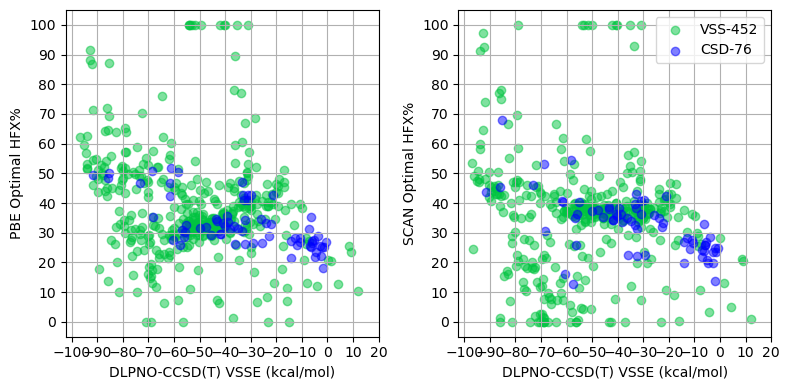

In [3]:
#true distribution

fig, ax = plt.subplots(figsize=(8,4), ncols=2)

csd_hfx_df['target SSE'] = [csd_76['dlpno-CCSD_T.vertsse'][structure] for structure in csd_hfx_df.index]
vss_hfx_df['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in vss_hfx_df.index]

ax[0].scatter(vss_hfx_df['target SSE'], vss_hfx_df['hfx_pbe'], color='#00C440', label='VSS-452', alpha=0.5)
ax[0].scatter(csd_hfx_df['target SSE'], csd_hfx_df['hfx_pbe'], color='#0000FF', label='CSD-76', alpha=0.5)
ax[0].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[0].set_ylabel('PBE Optimal HFX%')
ax[0].set_xticks(np.arange(-100, 21, 10))
ax[0].set_yticks(np.arange(0, 101, 10))
ax[0].grid()

ax[1].scatter(vss_hfx_df['target SSE'], vss_hfx_df['hfx_scan'], color='#00C440', label='VSS-452', alpha=0.5)
ax[1].scatter(csd_hfx_df['target SSE'], csd_hfx_df['hfx_scan'], color='#0000FF', label='CSD-76', alpha=0.5)
ax[1].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1].set_ylabel('SCAN Optimal HFX%')
ax[1].set_xticks(np.arange(-100, 21, 10))
ax[1].set_yticks(np.arange(0, 101, 10))
ax[1].grid()

ax[1].legend()
fig.tight_layout();

In [4]:
pbe_test['energy error'] = np.abs(pbe_test['target SSE'] - pbe_test['predicted SSE'])
pbe_test.sort_values('energy error', ascending=False).head(10)

,PBE Prediction,PBE Target,predicted SSE,target SSE,energy error
Unnamed: 0,,,,,
Co_ZEZJAP_comp_0_222,24.399548,35.282440,-50.90682948448738,-68.385899,17.47907
Fe_KAWTUX_comp_2_33,28.503671,42.623520,-17.205321112682583,-29.782293,12.576972
Co_LOFFUH_comp_0_321,24.318149,35.319901,3.0553017884317932,-6.386751,9.442053
Mn_MEDHOS_comp_0_3111,16.510690,26.544647,-19.907982721186595,-29.170980,9.262997
Co_YICJAV_comp_0_411,20.697447,31.167984,1.3008299509565604,-7.058424,8.359254
Fe_DETTUR_comp_0_33,50.833558,42.759628,-40.730750006367536,-32.972110,7.75864
Co_DOCZOK_comp_0_2211,17.152014,27.092896,1.5088110021380219,-5.868916,7.377727
Mn_FARTOH_comp_0_3111,38.197221,27.434921,-67.53100479256878,-60.433662,7.097343
Mn_FAMBOL_comp_1_111111,36.297092,48.322220,-78.8920817542791,-85.848274,6.956193


In [5]:
vss_hfx_df.loc[[x for x in pbe_train.index if x.startswith('co')]].sort_values('target SSE', ascending=True).head(10)

,hfx_pbe,hfx_scan,target SSE
Unnamed: 0,,,
co_3_cs-C-0-0_cs-C-0-0_cs-C-0-0_cs-C-0-0_hydroxyl-O-0-d1_hydroxyl-O-0-d1_5,25.080185,31.419296,-56.389550
co_3_furan-O-0-0_furan-O-0-0_furan-O-0-0_amine-N-0-d1_furan-O-0-0_amine-N-0-d1_5,7.395401,0.000000,-43.249790
co_2_SH2-S-0-0_SH2-S-0-0_SH2-S-0-0_water-O-0-0_water-O-0-0_water-O-0-0_4,46.165619,44.099960,-42.305274
co_2_carboxyl-O-1-d1_carboxyl-O-1-d1_carboxyl-O-1-d1_pyridine-N-3-0_carboxyl-O-1-d1_pyridine-N-3-0_4,100.000000,100.000000,-40.541826
co_3_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_fluoride-F-0-d1_fluoride-F-0-d1_5,28.052673,31.340179,-39.746456
co_2_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_acetonitrile-N-1-0_4,46.847000,45.571518,-37.967602
co_2_water-O-0-0_water-O-0-0_water-O-0-0_water-O-0-0_furan-O-0-0_furan-O-0-0_4,34.668961,33.899231,-37.899988
co_2_furan-O-0-0_furan-O-0-0_furan-O-0-0_acetonitrile-N-1-0_furan-O-0-0_acetonitrile-N-1-0_4,36.323395,35.508194,-37.462633
co_3_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_carboxyl-O-1-d1_carboxyl-O-1-d1_5,1.354370,0.000000,-37.106161


In [6]:
vss_hfx_df.loc[[x for x in pbe_train.index if x.startswith('mn')]].sort_values('target SSE', ascending=False).head(10)

,hfx_pbe,hfx_scan,target SSE
Unnamed: 0,,,
mn_2_cs-C-0-0_cs-C-0-0_cs-C-0-0_cs-C-0-0_thiocyanate-S-0-d1_thiocyanate-S-0-d1_6,62.215118,66.653900,-64.177688
mn_3_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_cs-C-0-0_cs-C-0-0_cs-C-0-0_5,34.936066,26.803436,-66.381545
mn_3_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_pyridine-N-3-0_imidazole-N-2-0_pyridine-N-3-0_5,17.754135,8.536530,-66.844038
mn_3_cyanide-C-0-d1_cyanide-C-0-d1_imidazole-N-2-0_imidazole-N-2-0_cyanide-C-0-d1_imidazole-N-2-0_5,32.471237,21.656876,-68.123090
mn_3_cs-C-0-0_cs-C-0-0_cs-C-0-0_hydroxyl-O-0-d1_cs-C-0-0_hydroxyl-O-0-d1_5,35.292969,22.530441,-68.820267
mn_3_carbonyl-C-0-0_carbonyl-C-0-0_carbonyl-C-0-0_chloride-Cl-0-d1_carbonyl-C-0-0_chloride-Cl-0-d1_5,29.248047,21.093140,-69.701102
mn_2_misc-C-4-0_misc-C-4-0_misc-C-4-0_misc-C-4-0_misc-C-4-0_cs-C-0-0_6,47.211380,43.050003,-70.049424
mn_2_misc-C-4-0_misc-C-4-0_misc-C-4-0_misc-C-4-0_cs-C-0-0_cs-C-0-0_6,47.814331,43.884201,-70.572433
mn_3_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_thiocyanate-S-0-d1_thiocyanate-S-0-d1_5,24.332504,13.271179,-71.591705


# Different answer than average for metal

The average optimal PBE HFX in the training set for metal Mn is 47.460.
The stdev in optimal PBE HFX in the training set for metal Mn is 16.757.
The average optimal PBE HFX in the validation set for metal Mn is 37.273.
The stdev in optimal PBE HFX in the validation set for metal Mn is 19.118.
The average optimal PBE HFX in the test set for metal Mn is 36.283.
The stdev in optimal PBE HFX in the test set for metal Mn is 12.198.
The mean optimal HFX for similar ligands in the training set is 53.166.


/tmp/ipykernel_2667655/2176762979.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

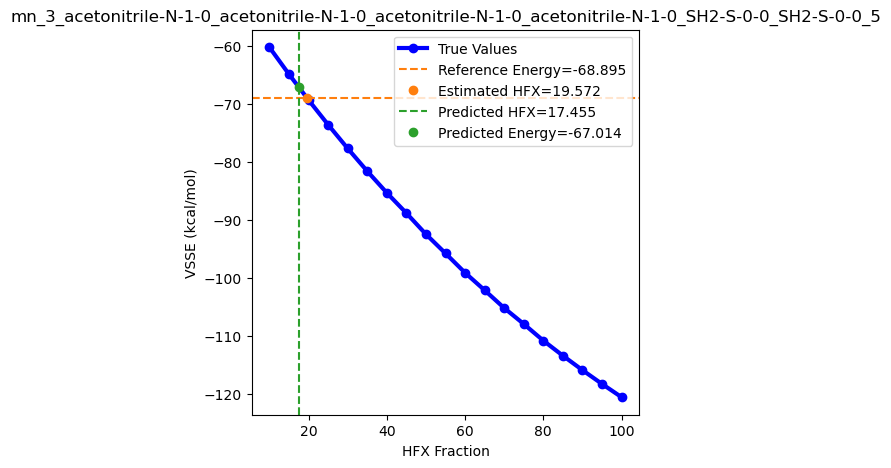

<Figure size 640x480 with 0 Axes>

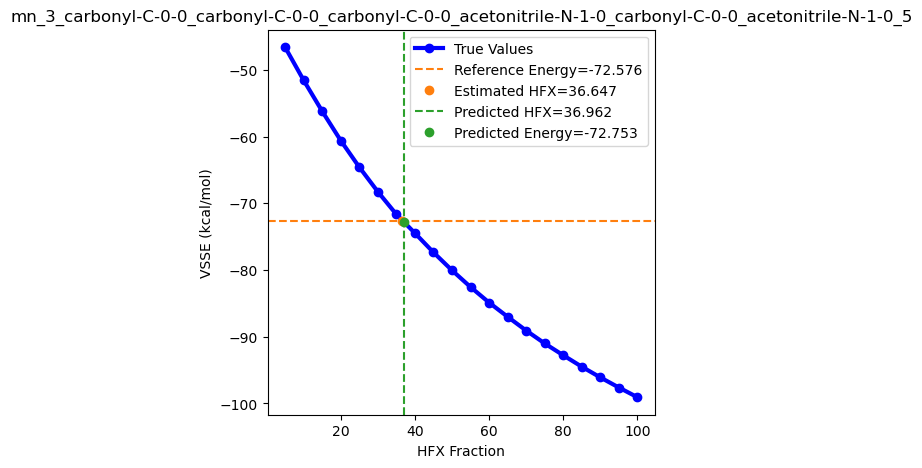

<Figure size 640x480 with 0 Axes>

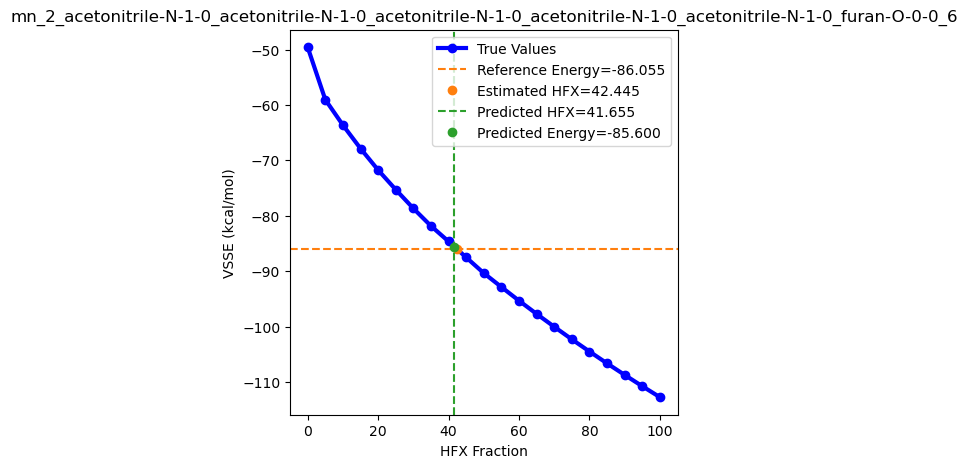

<Figure size 640x480 with 0 Axes>

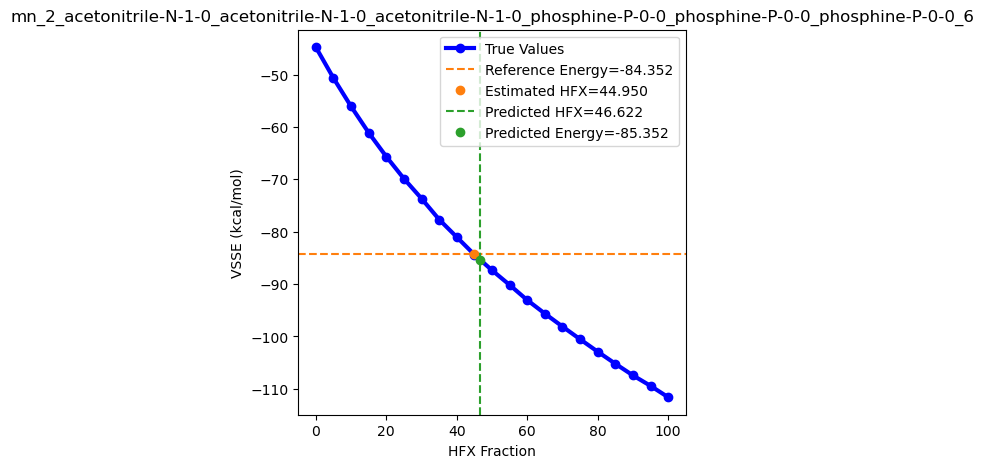

<Figure size 640x480 with 0 Axes>

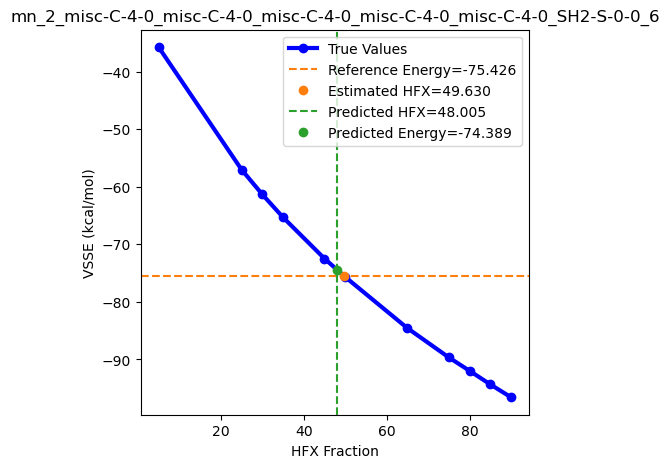

<Figure size 640x480 with 0 Axes>

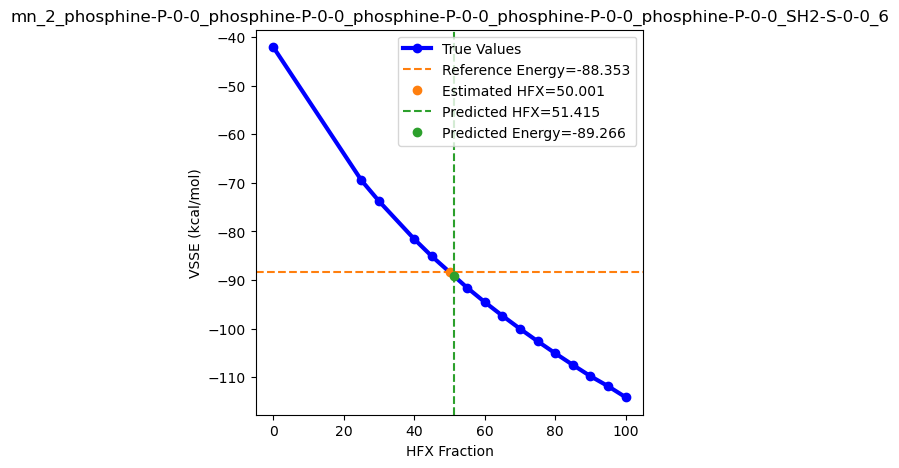

<Figure size 640x480 with 0 Axes>

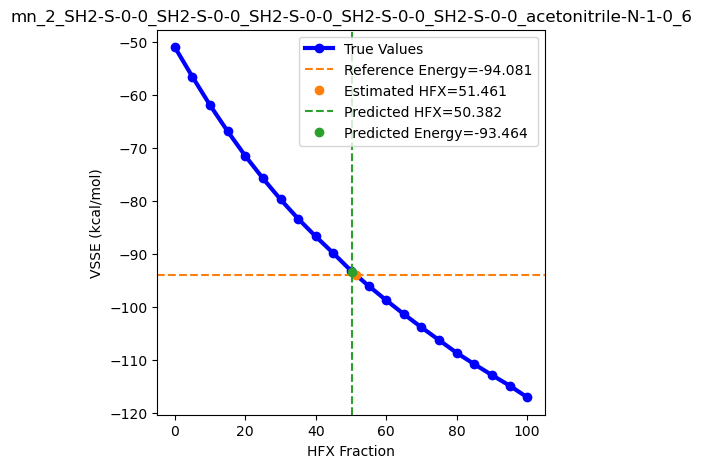

<Figure size 640x480 with 0 Axes>

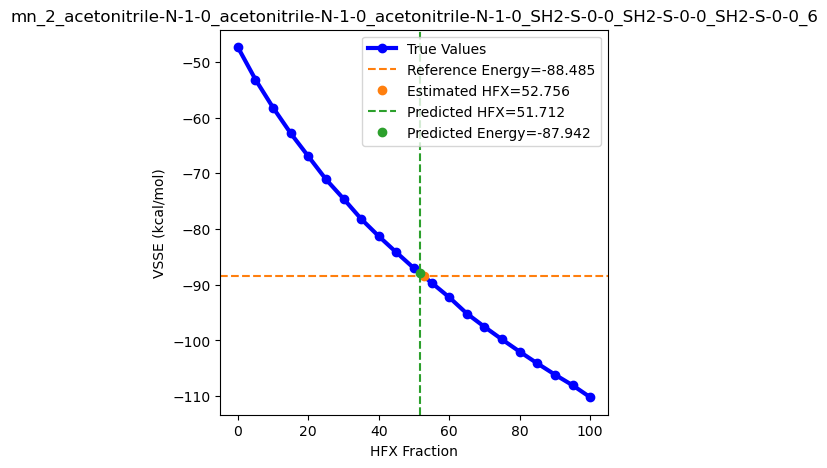

<Figure size 640x480 with 0 Axes>

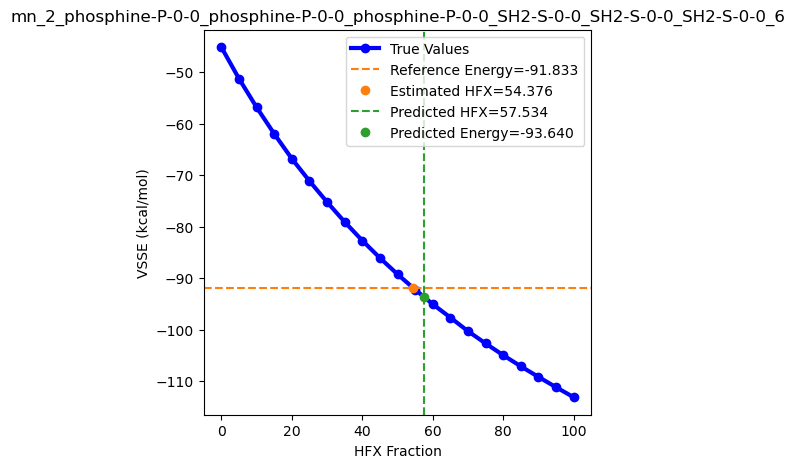

<Figure size 640x480 with 0 Axes>

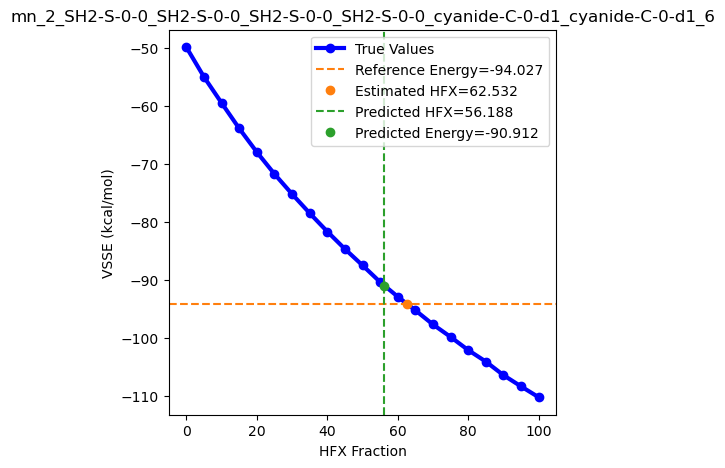

<Figure size 640x480 with 0 Axes>

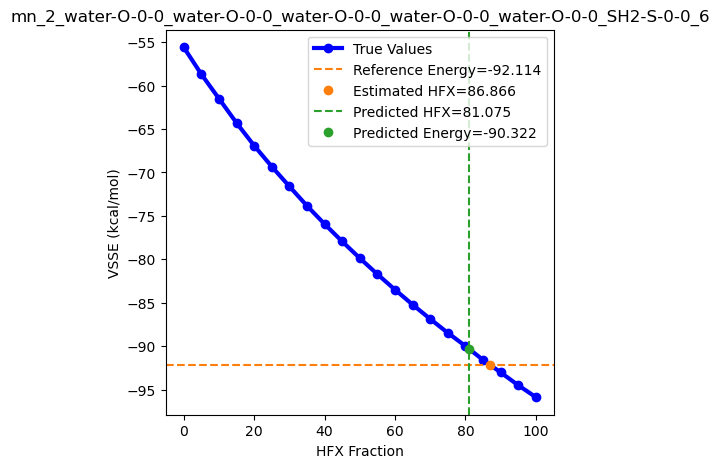

In [7]:
metal = 'mn'

train_structs = pbe_train.loc[[x for x in pbe_train.index if x.startswith(metal)]]
print(f'The average optimal PBE HFX in the training set for metal {metal.capitalize()} is {train_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the training set for metal {metal.capitalize()} is {train_structs["PBE Target"].std():1.3f}.')

val_structs = pbe_val.loc[[x for x in pbe_val.index if x.startswith(metal)]]
print(f'The average optimal PBE HFX in the validation set for metal {metal.capitalize()} is {val_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the validation set for metal {metal.capitalize()} is {val_structs["PBE Target"].std():1.3f}.')

test_structs = pbe_test.loc[[x for x in pbe_test.index if x.startswith(metal.capitalize())]]
print(f'The average optimal PBE HFX in the test set for metal {metal.capitalize()} is {test_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the test set for metal {metal.capitalize()} is {test_structs["PBE Target"].std():1.3f}.')

val_structs['train_dev'] = np.abs(val_structs['PBE Target'] - train_structs['PBE Target'].mean())
val_structs['hfx_res'] = np.abs(val_structs['PBE Target'] - val_structs['PBE Prediction'])
val_structs['energy_res'] = np.abs(val_structs['target SSE'] - val_structs['predicted SSE'])
val_structs.sort_values('train_dev', ascending=False)

lig1 = 'acetonitrile'
lig2 = 'SH2'

similar = pbe_train.loc[[x for x in pbe_train.index if x.startswith(metal) and (lig1 in x or lig2 in x)]]
print(f'The mean optimal HFX for similar ligands in the training set is {similar["PBE Target"].mean():1.3f}.')

similar.sort_values('PBE Target', ascending=True)

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def sse_vs_hfx(structure, dataset, pbe_pred):
    #target_names is a list of the names of targets for PBE and SCAN, respectively.
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    reference = df.loc[structure]['dlpno-CCSD_T.vertsse']
    plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for idx, functional in enumerate(['pbe']):
        all_increments = np.arange(0, 101, 5)
        increments = []
        sses = []
        for i, increment in enumerate(all_increments):
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                sses.append(sse)
                increments.append(increment)
        ax.plot(increments, sses, '-o', label='True Values', linewidth=3, color='b')
        ax.set_xlabel('HFX Fraction')
        ax.set_ylabel('VSSE (kcal/mol)')
        #ax.set_title(structure + ', ' + functional)
        if len(increments) < 5:
            print('Not enough converged values!')
            continue
        
        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')

        #ax[idx].plot(np.arange(0, 101, 1), line(np.arange(0, 101, 1)), label='Line (closest 2)')
        ax.axhline(reference, linestyle='--', label=f'Reference Energy={reference:1.3f}', color='C1')
        hfx = hfx_df.loc[structure]['hfx_' + functional]
        ax.plot(hfx, line(hfx), 'o', label=f'Estimated HFX={hfx:1.3f}', color='C1')
        ax.axvline(pbe_pred, linestyle='--', color='C2', label=f'Predicted HFX={pbe_pred:1.3f}')
        pred_df = pd.DataFrame(columns=['PBE Prediction'], index=[structure])
        pred_df['PBE Prediction'] = pbe_pred
        if pred_energy(structure, functional, dataset, pred_df) is not None:
            ax.plot(pbe_pred, pred_energy(structure, functional, dataset, pred_df), 'o', color='C2', label=f'Predicted Energy={pred_energy(structure, functional, dataset, pred_df):1.3f}')
        ax.legend()
        ax.set_title(structure)

sse_vs_hfx('mn_3_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_SH2-S-0-0_SH2-S-0-0_5',
           'vss', 17.4547)

for idx, row in similar.sort_values('PBE Target', ascending=True).iterrows():
    sse_vs_hfx(idx, 'vss', row['PBE Prediction'])

The average optimal PBE HFX in the training set for metal Co is 39.454.
The stdev in optimal PBE HFX in the training set for metal Co is 18.304.
The average optimal PBE HFX in the validation set for metal Co is 33.871.
The stdev in optimal PBE HFX in the validation set for metal Co is 7.802.
The average optimal PBE HFX in the test set for metal Co is 27.002.
The stdev in optimal PBE HFX in the test set for metal Co is 3.917.
The mean optimal HFX for similar ligands in the training set is 33.133.


/tmp/ipykernel_2667655/2176762979.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

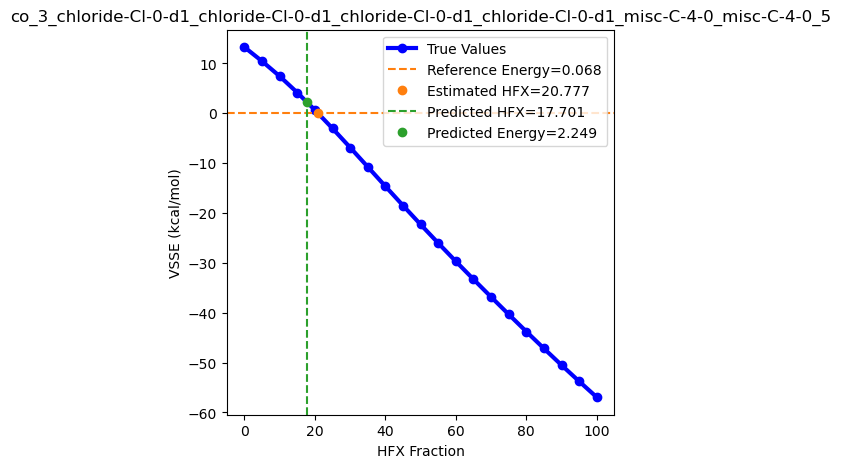

<Figure size 640x480 with 0 Axes>

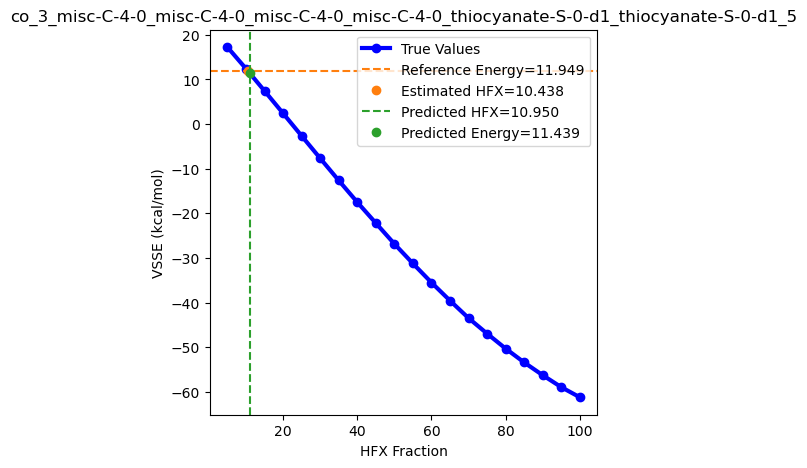

<Figure size 640x480 with 0 Axes>

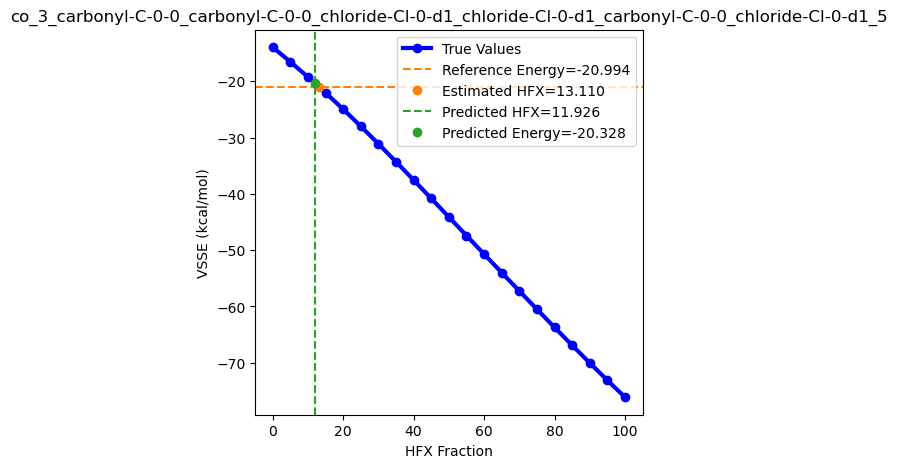

<Figure size 640x480 with 0 Axes>

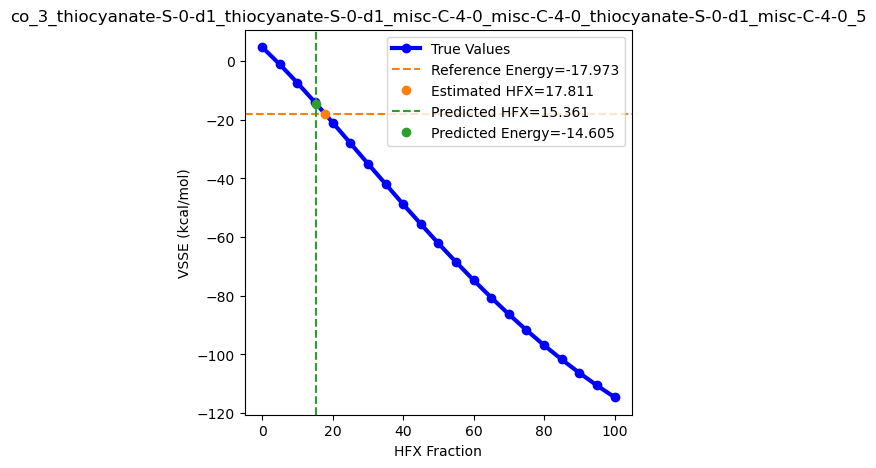

<Figure size 640x480 with 0 Axes>

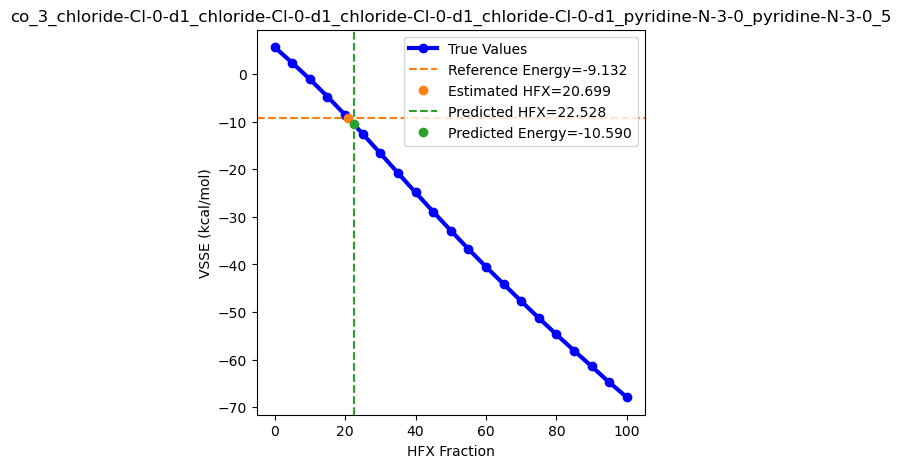

<Figure size 640x480 with 0 Axes>

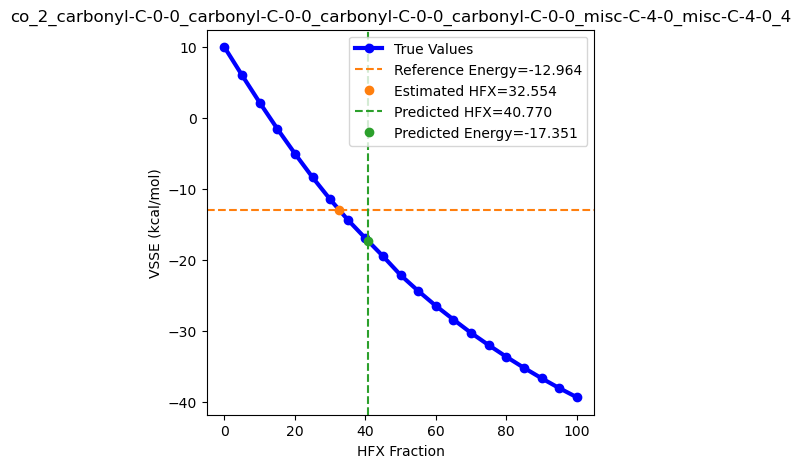

<Figure size 640x480 with 0 Axes>

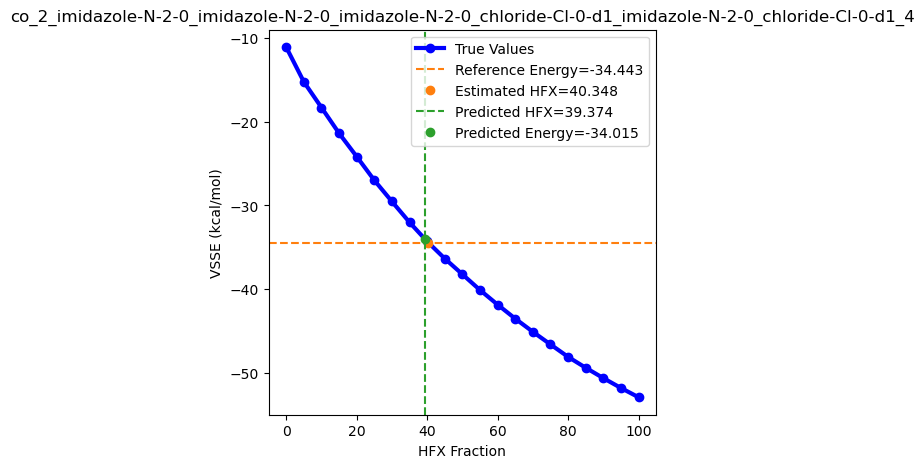

<Figure size 640x480 with 0 Axes>

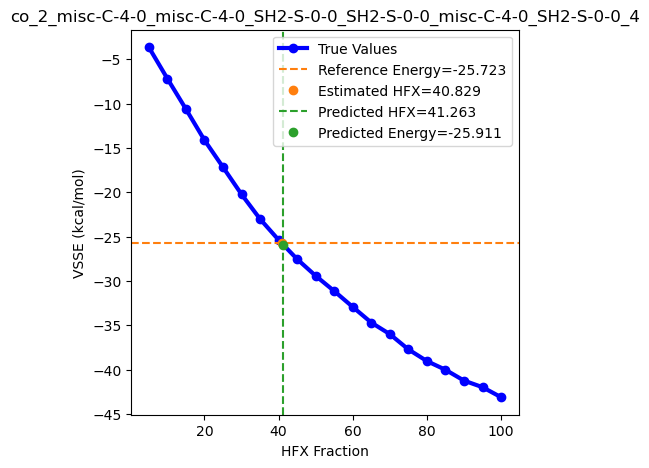

<Figure size 640x480 with 0 Axes>

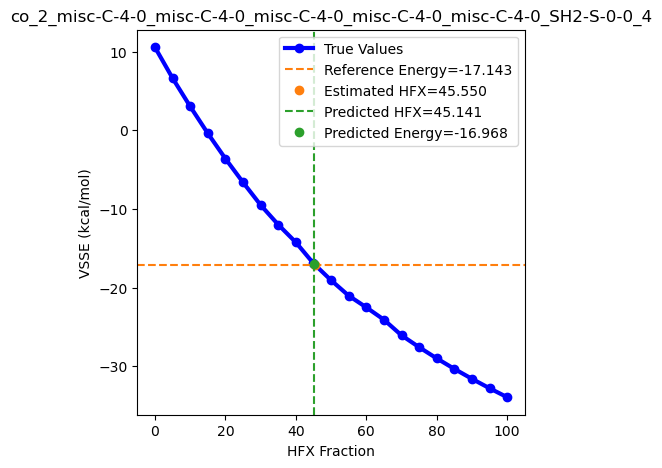

<Figure size 640x480 with 0 Axes>

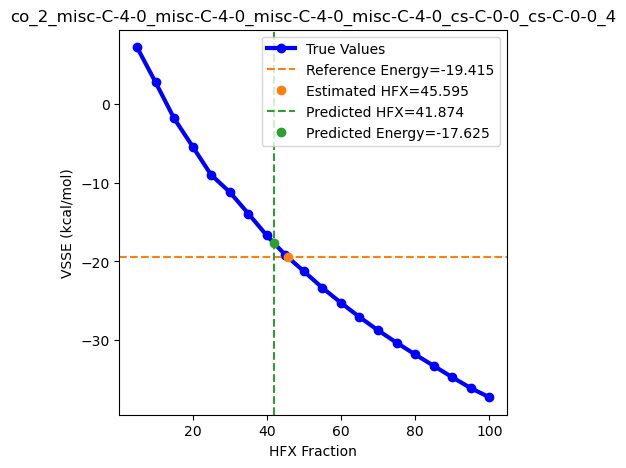

<Figure size 640x480 with 0 Axes>

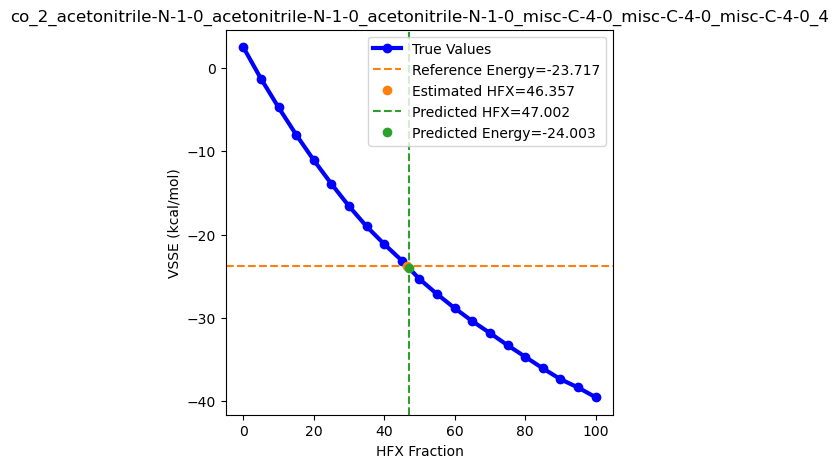

<Figure size 640x480 with 0 Axes>

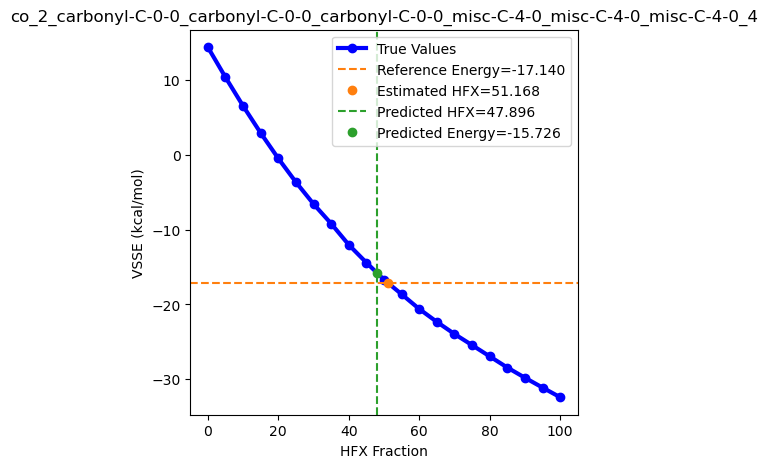

In [8]:
metal = 'co'

train_structs = pbe_train.loc[[x for x in pbe_train.index if x.startswith(metal)]]
print(f'The average optimal PBE HFX in the training set for metal {metal.capitalize()} is {train_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the training set for metal {metal.capitalize()} is {train_structs["PBE Target"].std():1.3f}.')

val_structs = pbe_val.loc[[x for x in pbe_val.index if x.startswith(metal)]]
print(f'The average optimal PBE HFX in the validation set for metal {metal.capitalize()} is {val_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the validation set for metal {metal.capitalize()} is {val_structs["PBE Target"].std():1.3f}.')

test_structs = pbe_test.loc[[x for x in pbe_test.index if x.startswith(metal.capitalize())]]
print(f'The average optimal PBE HFX in the test set for metal {metal.capitalize()} is {test_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the test set for metal {metal.capitalize()} is {test_structs["PBE Target"].std():1.3f}.')

val_structs['train_dev'] = np.abs(val_structs['PBE Target'] - train_structs['PBE Target'].mean())
val_structs['hfx_res'] = np.abs(val_structs['PBE Target'] - val_structs['PBE Prediction'])
val_structs['energy_res'] = np.abs(val_structs['target SSE'] - val_structs['predicted SSE'])
val_structs.sort_values('train_dev', ascending=False)

lig1 = 'chloride'
lig2 = 'misc'

similar = pbe_train.loc[[x for x in pbe_train.index if x.startswith(metal) and (lig1 in x or lig2 in x)]]
print(f'The mean optimal HFX for similar ligands in the training set is {similar["PBE Target"].mean():1.3f}.')

similar.sort_values('PBE Target', ascending=True)

sse_vs_hfx('co_3_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_misc-C-4-0_misc-C-4-0_5',
           'vss', 17.700891)

for idx, row in similar.sort_values('PBE Target', ascending=True).iterrows():
    sse_vs_hfx(idx, 'vss', row['PBE Prediction'])

The average optimal PBE HFX in the training set for metal Fe is 35.498.
The stdev in optimal PBE HFX in the training set for metal Fe is 7.341.
The average optimal PBE HFX in the validation set for metal Fe is 36.451.
The stdev in optimal PBE HFX in the validation set for metal Fe is 7.706.
The average optimal PBE HFX in the test set for metal Fe is 35.721.
The stdev in optimal PBE HFX in the test set for metal Fe is 7.262.
The mean optimal HFX for similar ligands in the training set is 35.783.


/tmp/ipykernel_2667655/2176762979.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

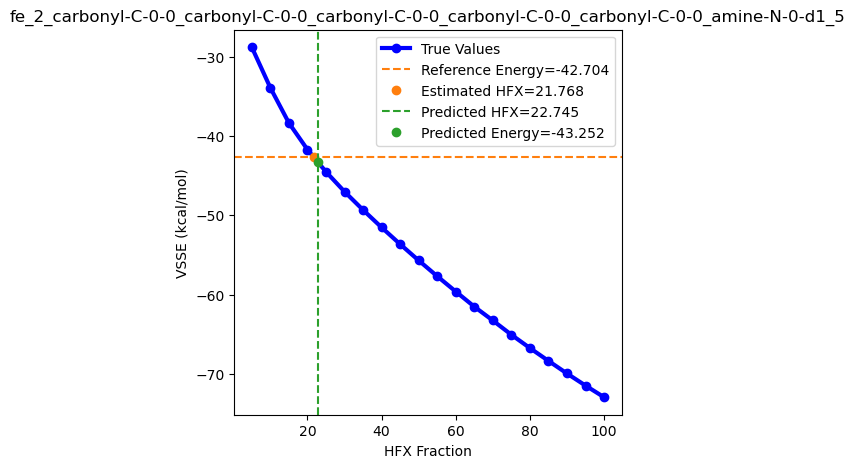

<Figure size 640x480 with 0 Axes>

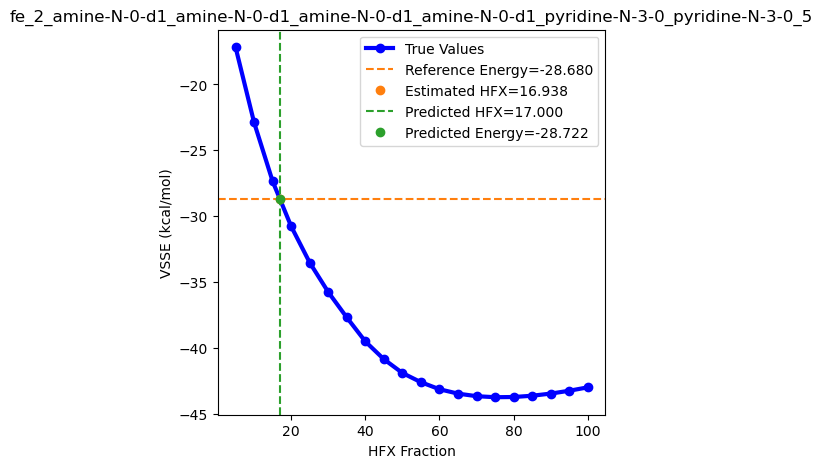

<Figure size 640x480 with 0 Axes>

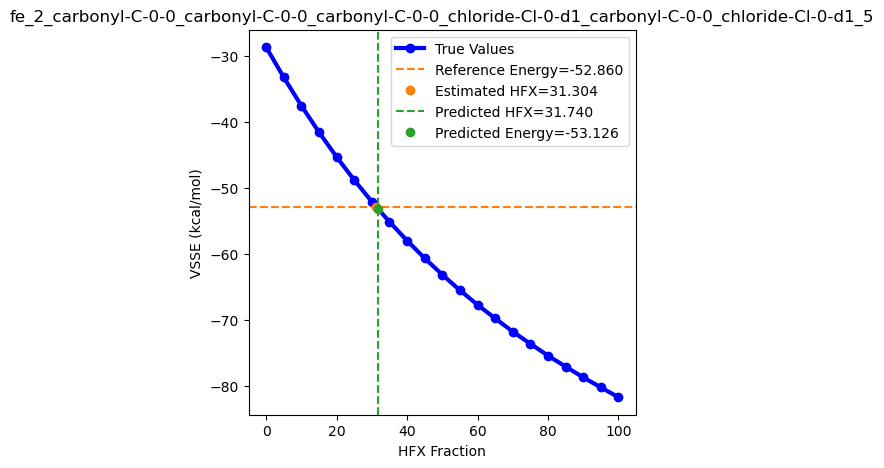

<Figure size 640x480 with 0 Axes>

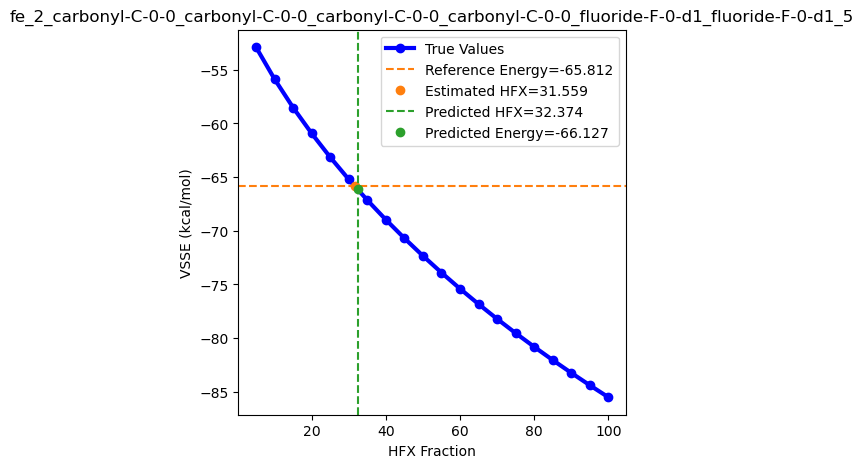

<Figure size 640x480 with 0 Axes>

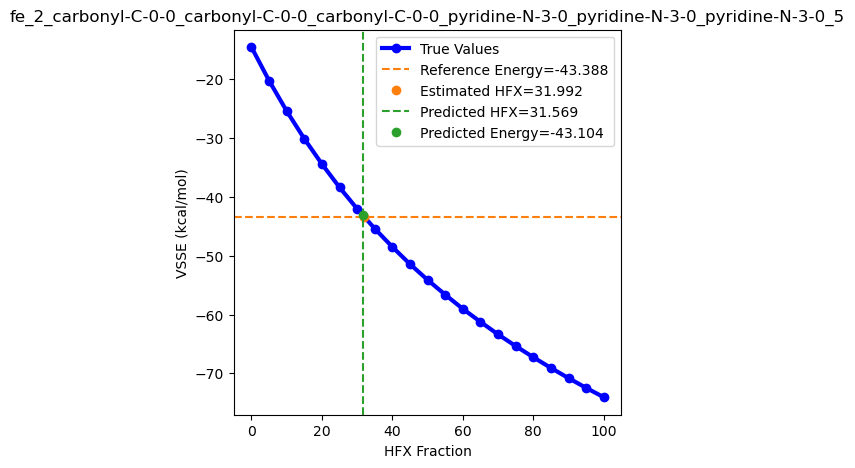

<Figure size 640x480 with 0 Axes>

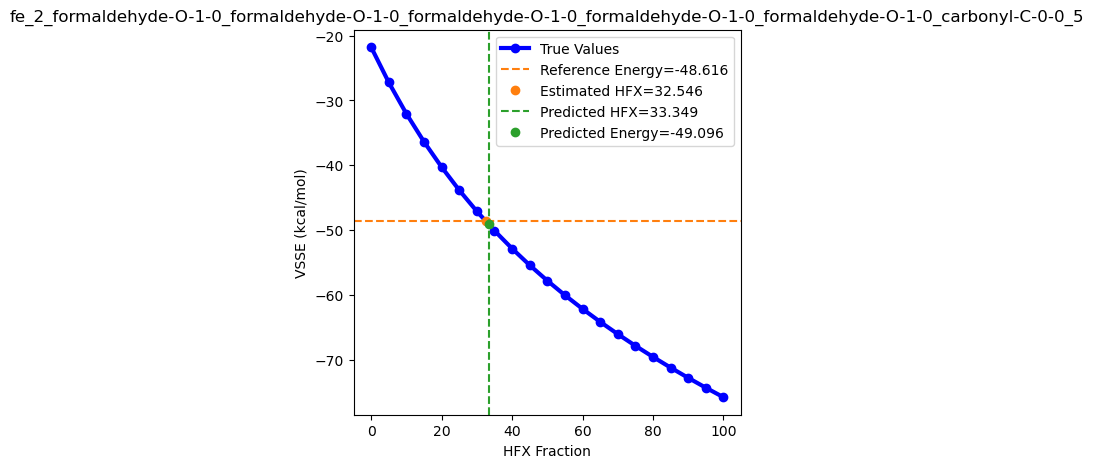

<Figure size 640x480 with 0 Axes>

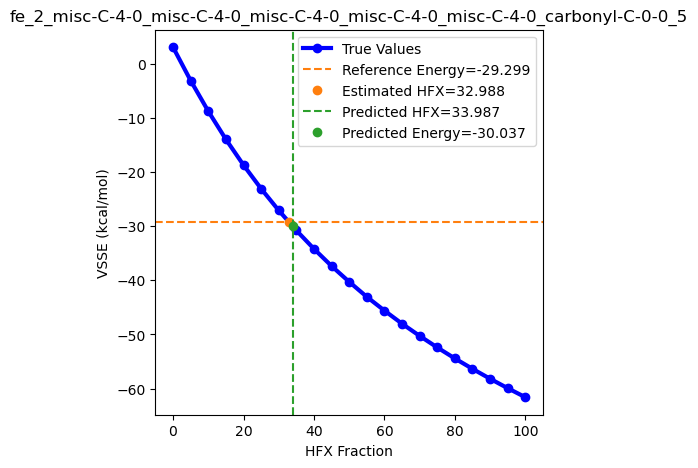

<Figure size 640x480 with 0 Axes>

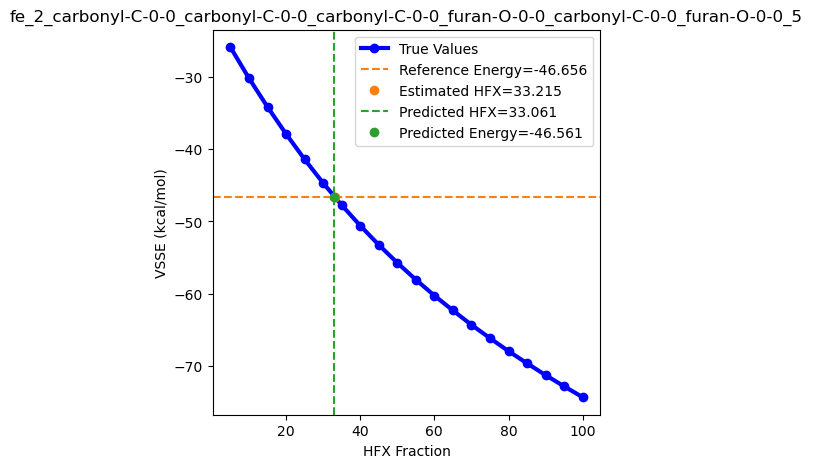

<Figure size 640x480 with 0 Axes>

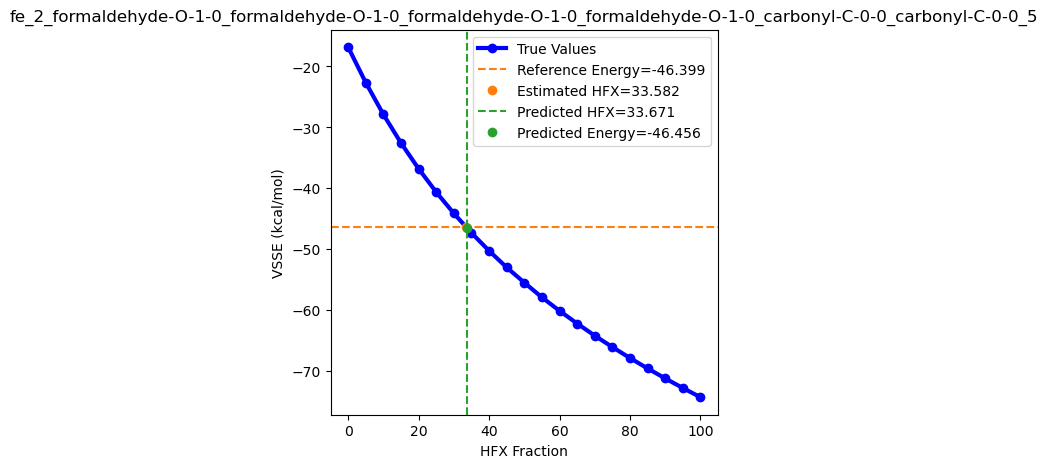

<Figure size 640x480 with 0 Axes>

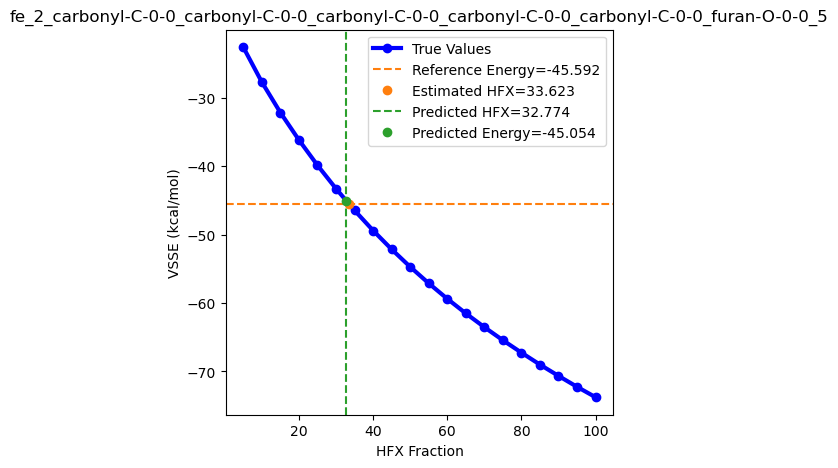

<Figure size 640x480 with 0 Axes>

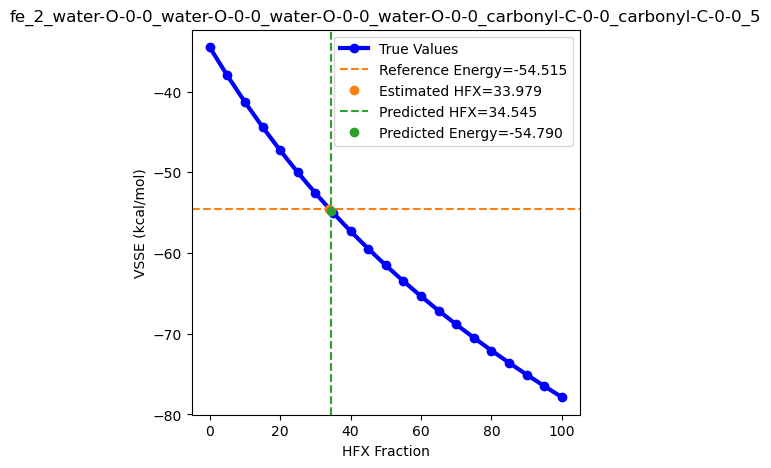

<Figure size 640x480 with 0 Axes>

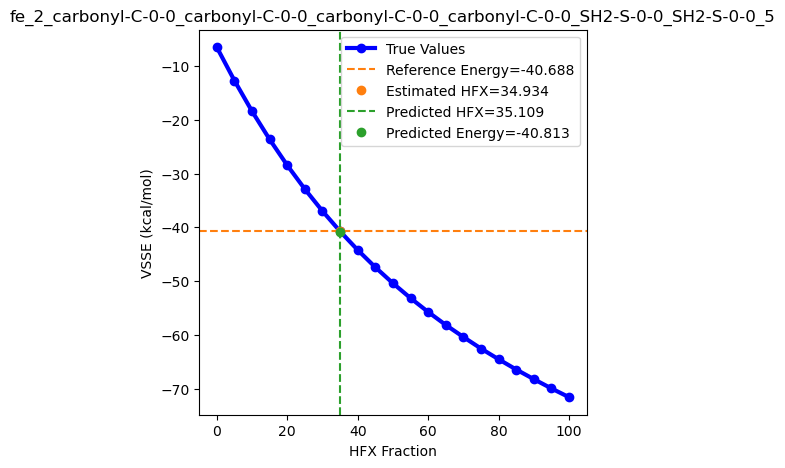

<Figure size 640x480 with 0 Axes>

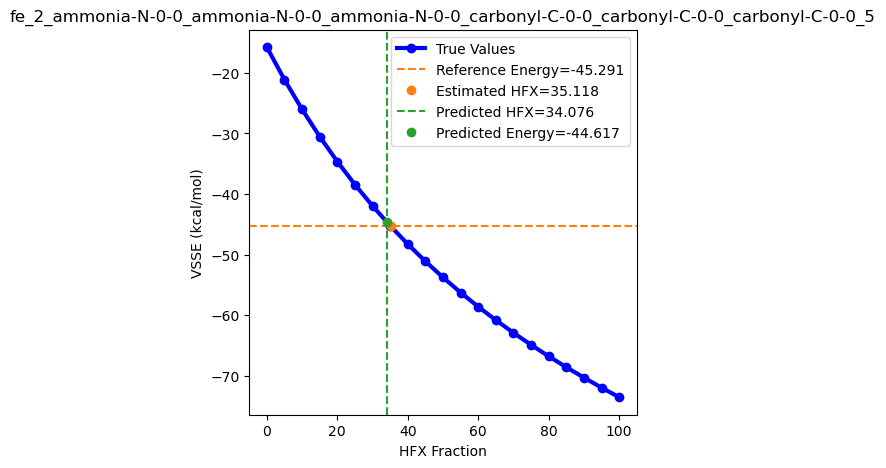

<Figure size 640x480 with 0 Axes>

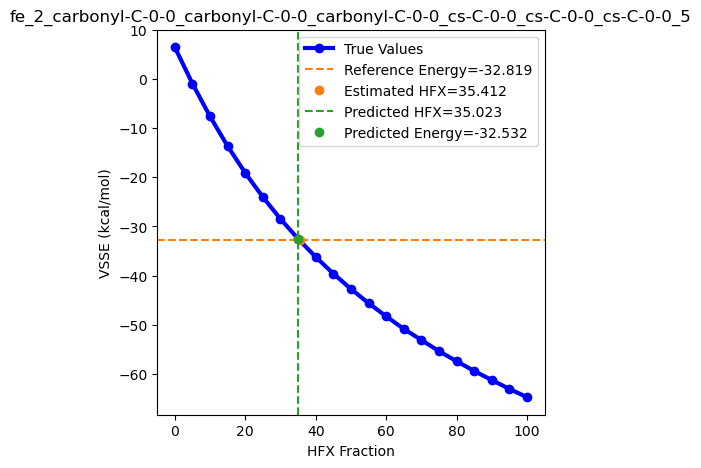

<Figure size 640x480 with 0 Axes>

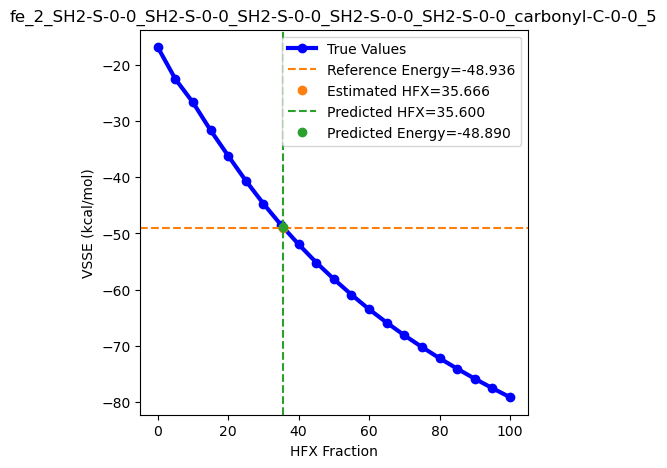

<Figure size 640x480 with 0 Axes>

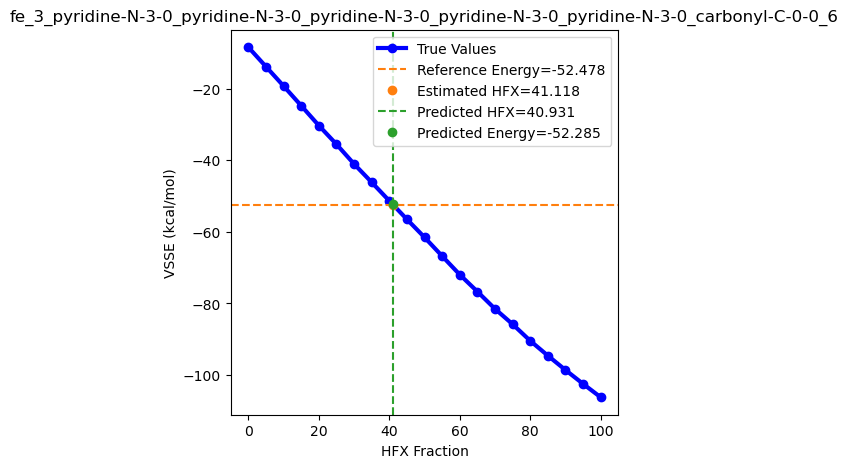

<Figure size 640x480 with 0 Axes>

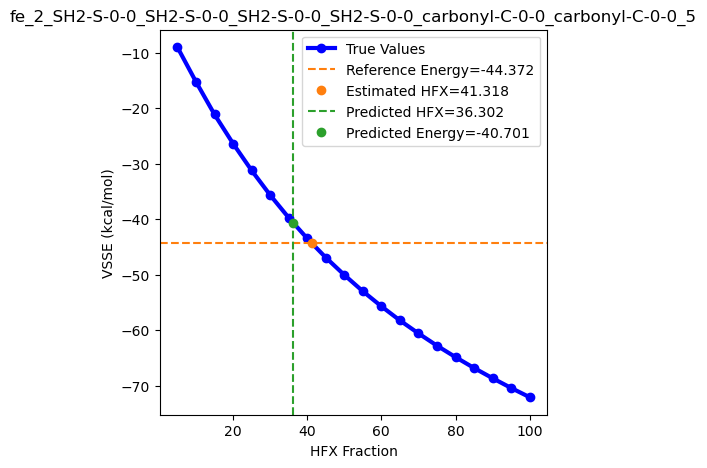

<Figure size 640x480 with 0 Axes>

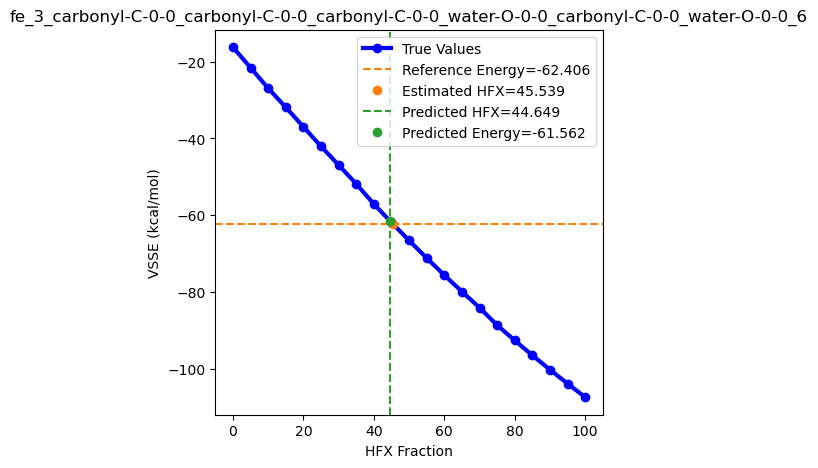

<Figure size 640x480 with 0 Axes>

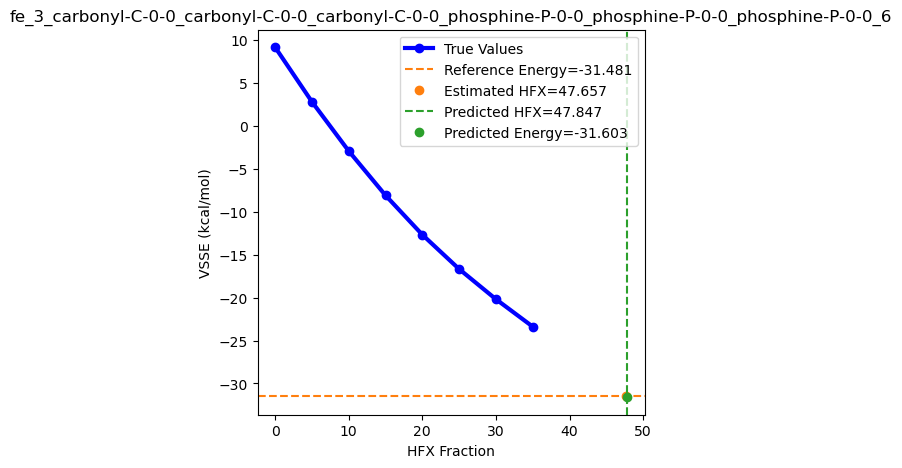

<Figure size 640x480 with 0 Axes>

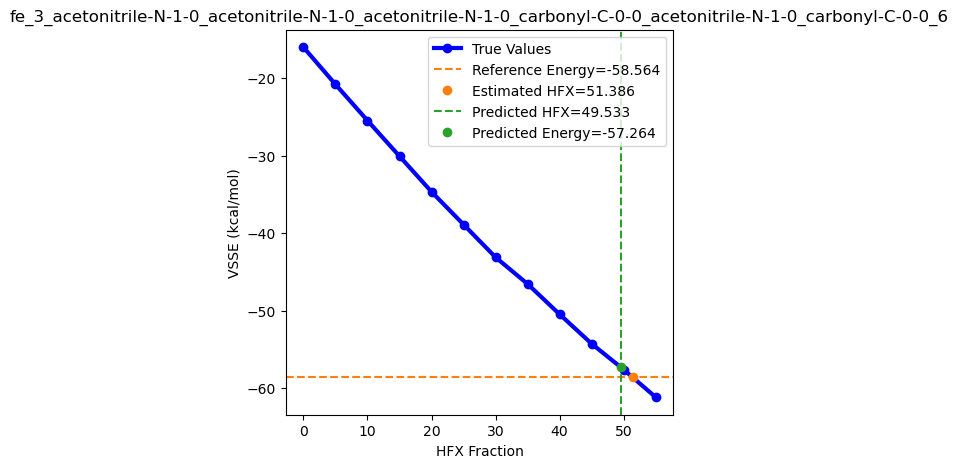

In [9]:
metal = 'fe'

train_structs = pbe_train.loc[[x for x in pbe_train.index if x.startswith(metal)]]
print(f'The average optimal PBE HFX in the training set for metal {metal.capitalize()} is {train_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the training set for metal {metal.capitalize()} is {train_structs["PBE Target"].std():1.3f}.')

val_structs = pbe_val.loc[[x for x in pbe_val.index if x.startswith(metal)]]
print(f'The average optimal PBE HFX in the validation set for metal {metal.capitalize()} is {val_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the validation set for metal {metal.capitalize()} is {val_structs["PBE Target"].std():1.3f}.')

test_structs = pbe_test.loc[[x for x in pbe_test.index if x.startswith(metal.capitalize())]]
print(f'The average optimal PBE HFX in the test set for metal {metal.capitalize()} is {test_structs["PBE Target"].mean():1.3f}.')
print(f'The stdev in optimal PBE HFX in the test set for metal {metal.capitalize()} is {test_structs["PBE Target"].std():1.3f}.')

val_structs['train_dev'] = np.abs(val_structs['PBE Target'] - train_structs['PBE Target'].mean())
val_structs['hfx_res'] = np.abs(val_structs['PBE Target'] - val_structs['PBE Prediction'])
val_structs['energy_res'] = np.abs(val_structs['target SSE'] - val_structs['predicted SSE'])
val_structs.sort_values('train_dev', ascending=False)

lig1 = 'carbonyl'
lig2 = 'amine'

similar = pbe_train.loc[[x for x in pbe_train.index if x.startswith(metal) and (lig1 in x or lig2 in x)]]
print(f'The mean optimal HFX for similar ligands in the training set is {similar["PBE Target"].mean():1.3f}.')

similar.sort_values('PBE Target', ascending=True)

sse_vs_hfx('fe_2_carbonyl-C-0-0_carbonyl-C-0-0_carbonyl-C-0-0_carbonyl-C-0-0_carbonyl-C-0-0_amine-N-0-d1_5',
           'vss', 22.744874)

for idx, row in similar.sort_values('PBE Target', ascending=True).iterrows():
    sse_vs_hfx(idx, 'vss', row['PBE Prediction'])
